In [ ]:
import os
import gc
import time
import copy
import optuna

from pathlib import Path

import numpy as np, pandas as pd, polars as pl

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingClassifier

from sklearn.utils import resample

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

import lightgbm as lgb, catboost as cb, xgboost as xgb

from optuna.samplers import TPESampler

from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
# from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import NearMiss, TomekLinks
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt

# IMAGE PREDICTIONS

In [ ]:
# # #EFFNET V1B0
# !python /kaggle/input/isic-script-inference-effnetv1b0-f313ae/main.py /kaggle/input/isic-pytorch-training-baseline-image-only/AUROC0.5171_Loss0.3476_epoch35.bin
# !mv submission.csv submission_effnetv1b0.csv

!python /kaggle/input/k/annapantyukhina/isic-script-inference-effnetv1b0-f313ae/main.py /kaggle/input/isic-pytorch-training-baseline-image-only/AUROC0.5171_Loss0.3476_epoch35.bin
!mv submission.csv submission_effnetv1b0.csv

BEST_WEIGHT = /kaggle/input/isic-pytorch-training-baseline-image-only/AUROC0.5171_Loss0.3476_epoch35.bin
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


In [ ]:
# # #TARGET 3
# !python /kaggle/input/isic-2024-pl-submission-script-and-preds/pl_submission.py
# !mv submission.csv submission_image3.csv

!python /kaggle/input/isic-2024-pl-submission-script-and-preds/pl_submission.py
!mv submission.csv submission_image3.csv

/kaggle/input/isic-2024-pl-submission-script-and-preds/pl_submission.py:25: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_meta = pd.read_csv(BASE_DATA_DIR + "train-metadata.csv")


In [ ]:
# # #EVA02
# !python /kaggle/input/isic-script-inference-eva02/main.py /kaggle/input/isic-pytorch-training-baseline-eva02/AUROC0.5177_Loss0.2829_epoch7.bin
# !mv submission.csv submission_eva02.csv

In [ ]:
# #EDGENEXT
# !python /kaggle/input/isic-script-inference-edgenext/main.py /kaggle/input/isic-pytorch-training-edgenext/Final_model.bin
# !mv submission.csv submission_edgenext.csv

# DATA PREPROCESS

In [ ]:
root = Path('/kaggle/input/isic-2024-challenge')

train_path = root / 'train-metadata.csv'
test_path = root / 'test-metadata.csv'
subm_path = root / 'sample_submission.csv'

id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = [
    'lesion_size_ratio',                 # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',                # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                      # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',                # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',           # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt
    'border_complexity',                 # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',                  # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',              # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',           # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',           # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',           # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',       # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',       # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',                 # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',                 # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',              # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',         # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',             # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',            # border_complexity       + lesion_shape_index
    'color_contrast_index',              # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',                   # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',            # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',               # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',                  # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',       # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',             # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',          # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',    # tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',        # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',              # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',          # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',         # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',    # tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',             # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',           # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                       # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',           # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',               # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',           # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',           # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis

     ###########NEW###################

    'lesion_compactness',               # tbp_lv_perimeterMM**2 / tbp_lv_areaMM2
    'ellipticity_index',                # (clin_size_long_diam_mm - tbp_lv_minorAxisMM) / clin_size_long_diam_mm
    'border_irregularity_index',        # tbp_lv_norm_border / tbp_lv_area_perim_ratio
    'lesion_color_intensity',           # (tbp_lv_L * tbp_lv_A * tbp_lv_B) / 1000
    'lesion_color_contrast_norm',       # lesion_color_difference / (tbp_lv_Lext + tbp_lv_Aext + tbp_lv_Bext)
    'lesion_circularity',               # (4 * pi * tbp_lv_areaMM2) / tbp_lv_perimeterMM**2
    'volume_to_area_ratio',             # volume_approximation_3d / tbp_lv_areaMM2
    'lesion_spread_index',              # sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2) / tbp_lv_areaMM2
    'gradient_based_color_asymmetry',   # (tbp_lv_stdL - tbp_lv_stdLExt) / tbp_lv_stdL
    'symmetry_to_compactness_ratio',    # tbp_lv_symm_2axis / lesion_compactness
    'age_normalized_severity_index',    # lesion_severity_index / age_approx

    'color_homogeneity',                # 1 / (tbp_lv_radial_color_std_max + err)
    'border_to_hue_contrast_ratio',     # tbp_lv_norm_border / hue_contrast


]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient']
image_cols = ["target_3","target_effnetv1b0"]  #,"target_eva02" # ,"target_edgenext"]

#norm_cols += image_cols
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

In [ ]:
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), # You may want to impute test data with train
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            lesion_compactness             = (pl.col('tbp_lv_perimeterMM')**2) / pl.col('tbp_lv_areaMM2') ,
            ellipticity_index              = (pl.col('clin_size_long_diam_mm') - pl.col('tbp_lv_minorAxisMM')) / pl.col('clin_size_long_diam_mm'),
            border_irregularity_index      = pl.col('tbp_lv_norm_border') / pl.col('tbp_lv_area_perim_ratio'),
            lesion_color_intensity         = (pl.col('tbp_lv_L') * pl.col('tbp_lv_A') * pl.col('tbp_lv_B')) / 1000,
            lesion_color_contrast_norm     = pl.col('lesion_color_difference') / (pl.col('tbp_lv_Lext') + pl.col('tbp_lv_Aext') + pl.col('tbp_lv_Bext')),
            lesion_circularity             = (4 * np.pi * pl.col('tbp_lv_areaMM2')) / (pl.col('tbp_lv_perimeterMM')**2),
            volume_to_area_ratio           = pl.col('volume_approximation_3d') / pl.col('tbp_lv_areaMM2'),
            lesion_spread_index            = (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt() / pl.col('tbp_lv_areaMM2'),
            gradient_based_color_asymmetry = (pl.col('tbp_lv_stdL') - pl.col('tbp_lv_stdLExt')) / pl.col('tbp_lv_stdL'),
            age_normalized_severity_index  = pl.col('lesion_severity_index') / pl.col('age_approx'),
            color_homogeneity              = 1 / (pl.col('tbp_lv_radial_color_std_max') + err),
            border_to_hue_contrast_ratio   = pl.col('tbp_lv_norm_border') / pl.col('hue_contrast'),
#             relative_position_anatomical   = ((pl.col('tbp_lv_x') + pl.col('tbp_lv_y') + pl.col('tbp_lv_z'))/ pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location')    )    ,
        )
        .with_columns(
            symmetry_to_compactness_ratio  = pl.col('tbp_lv_symm_2axis') / pl.col('lesion_compactness')
        )

        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )

In [ ]:
def preprocess(df_train, df_test):
    global cat_cols

    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])

    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    # effnetv1b0
    df_eff = pd.read_csv("/kaggle/input/isic-inference-effnetv1b0-for-training-data/train_effnetv1b0.csv")
    df_train = df_train.reset_index(drop=True)
    df_eff = df_eff.reset_index(drop=True)
    df_train["target_effnetv1b0"] = df_eff["target_effnetv1b0"]
    df_eff = pd.read_csv("submission_effnetv1b0.csv")
    df_test = df_test.reset_index(drop=True)
    df_eff = df_eff.reset_index(drop=True)
    df_test["target_effnetv1b0"] = df_eff["target"]

    # target 3
    df_image_3 = pd.read_csv("/kaggle/input/isic-2024-pl-submission-script-and-preds/train_preds.csv")
    df_train = df_train.reset_index(drop=True)
    df_image_3 = df_image_3.reset_index(drop=True)
    df_train["target_3"] = df_image_3["pred"]
    df_3 = pd.read_csv("submission_image3.csv")
    df_test = df_test.reset_index(drop=True)
    df_image_3 = df_image_3.reset_index(drop=True)
    df_test["target_3"] = df_3["target"]

# #     #eva02
#     df_eva = pd.read_csv("/kaggle/input/isic-inference-eva02-for-training-data/train_eva02.csv")
#     df_train = df_train.reset_index(drop=True)
#     df_eva = df_eva.reset_index(drop=True)
#     df_eva = df_eva[["target_eva02"]]
#     df_train["target_eva02"] = df_eva["target_eva02"]
#     df_eva = pd.read_csv("submission_eva02.csv")
#     df_test = df_test.reset_index(drop=True)
#     df_eva = df_eva.reset_index(drop=True)
#     df_test["target_eva02"] = df_eva["target"]

#     #edgenext
#     df_ednx = pd.read_csv("/kaggle/input/isic-inference-edgenext-for-training-data/train_edgenext.csv")
#     df_train = df_train.reset_index(drop=True)
#     df_ednx = df_ednx.reset_index(drop=True)
#     df_ednx = df_ednx[['target_edgenext']]
#     df_train['target_edgenext'] = df_ednx['target_edgenext']
#     df_ednx = pd.read_csv("submission_edgenext.csv")
#     df_test = df_test.reset_index(drop=True)
#     df_ednx = df_ednx.reset_index(drop=True)
#     df_test ["target_edgenext"] = df_ednx['target']

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols

    return df_train, df_test

In [ ]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)

    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])

    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    return partial_auc

In [ ]:
df_train = read_data(train_path)

df_test = read_data(test_path)
df_subm = pd.read_csv(subm_path, index_col=id_col)

# ДОБАВЛЕН НИЖЕ
df_train, df_test = preprocess(df_train, df_test)

/tmp/ipykernel_18/416477245.py:16: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eff = pd.read_csv("/kaggle/input/isic-inference-effnetv1b0-for-training-data/train_effnetv1b0.csv")


In [ ]:
df_train

,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,onehot_39,onehot_40,onehot_41,onehot_42,onehot_43,onehot_44,onehot_45,onehot_46,target_effnetv1b0,target_3
0,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,...,0,0,0,0,0,1,0,0,0.576453,0.000046
1,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,...,0,0,0,0,0,1,0,0,0.562958,0.028392
2,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,...,0,0,0,0,0,1,0,0,0.021381,0.000174
3,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,...,0,1,0,0,0,0,0,0,0.608011,0.002001
4,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,...,0,0,0,0,0,1,0,0,0.443609,0.000145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,14.944666,...,0,0,1,0,0,0,0,0,0.806214,0.013333
401055,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,16.026870,...,0,0,0,0,0,1,0,0,0.160842,0.001346
401056,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,12.364397,...,0,0,0,0,1,0,0,0,0.125984,0.005390
401057,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,9.564721,...,0,0,0,0,0,0,1,0,0.141543,0.001180


# MODEL DEVELOPING

In [ ]:
feature_cols_without_image_cols = copy.copy(feature_cols)
feature_cols += image_cols

class SelectColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns]

In [ ]:
X = df_train[feature_cols]
y = df_train[target_col]
groups = df_train[group_col]

In [ ]:
def objective_lgb(trial):
    lgb_params = {
        'objective': 'binary',
        'verbosity': -1,
        'n_iter': 200,
        'boosting_type': 'gbdt',

        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 15, 250),
         'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 100, 1000),
         'max_bin': trial.suggest_int('max_bin', 50, 200),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.95),
        "bagging_freq":      trial.suggest_int("bagging_freq", 1, 7),
        'lambda_l2': trial.suggest_float("lambda_l1", 1e-4, 10.0, log=True),
        "lambda_l1":         trial.suggest_float("lambda_l1", 1e-4, 10.0, log=True),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 0.5, 6.0),
        'random_state': 42
    }

    lgb_model = Pipeline([
        ('sampler_1', RandomOverSampler(sampling_strategy=0.003, random_state=seed)),
        ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
        ('filter', SelectColumns(feature_cols_without_image_cols)),
        ('classifier', lgb.LGBMClassifier(**lgb_params)),
    ])

    cv = StratifiedGroupKFold(5, shuffle=True, random_state=seed)
    scores = cross_val_score(lgb_model, X, y, cv=cv, groups=groups, scoring=custom_metric)
    return np.mean(scores)

def objective_cb(trial):
    cb_params = {
        'loss_function':     'Logloss',
        'iterations':        200,
        'verbose':           False,
        'random_state':      seed,
        'learning_rate':     trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 4, 8),
        'l2_leaf_reg':       trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'subsample':         trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 1.0),
        'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 5, 100),
        'scale_pos_weight':  trial.suggest_float('scale_pos_weight', 0.8, 4.0),
        'bootstrap_type':    'Bernoulli',
        'cat_features':      cat_cols,
    }

    cb_model = Pipeline([
        ('sampler_1', RandomOverSampler(sampling_strategy=0.003, random_state=seed)),
        ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
        ('classifier', cb.CatBoostClassifier(**cb_params)),
    ])

    cv = StratifiedGroupKFold(5, shuffle=True, random_state=seed)
    scores = cross_val_score(cb_model, X, y, cv=cv, groups=groups, scoring=custom_metric)
    return np.mean(scores)

def objective_xgb(trial):
    xgb_params = {
         'objective':          'binary:logistic',
        'enable_categorical': True,
        'n_estimators':       200,
        'tree_method':        'hist',
        'random_state':       seed,
        'learning_rate':      trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth':          trial.suggest_int('max_depth', 4, 8),
        'lambda':             trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha':              trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'subsample':          trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree':   trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bynode':   trial.suggest_float('colsample_bynode', 0.4, 1.0),
        'scale_pos_weight':   trial.suggest_float('scale_pos_weight', 0.8, 4.0),
#         'enable_categorical': True,

    }

    xgb_model = Pipeline([
        ('sampler_1', RandomOverSampler(sampling_strategy=0.003, random_state=seed)),
        ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
        ('classifier', xgb.XGBClassifier(**xgb_params)),
    ])

    cv = StratifiedGroupKFold(5, shuffle=True, random_state=seed)
    scores = cross_val_score(xgb_model, X, y, cv=cv, groups=groups, scoring=custom_metric)
    return np.mean(scores)

In [ ]:
# Optimize CatBoost

study_cb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
study_cb.optimize(objective_cb, n_trials=35) #45
cb_params = study_cb.best_params

# # Optimize LightGBM
study_lgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
study_lgb.optimize(objective_lgb, n_trials=40) #50
lgb_params = study_lgb.best_params

# Optimize XGBoost
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
study_xgb.optimize(objective_xgb, n_trials=35) # 45
xgb_params = study_xgb.best_params

[I 2024-09-06 12:48:16,713] A new study created in memory with name: no-name-b454d489-a995-4744-b1ca-06b090275723
[I 2024-09-06 12:51:17,454] Trial 0 finished with value: 0.1846037100478931 and parameters: {'learning_rate': 0.023688639503640783, 'max_depth': 8, 'l2_leaf_reg': 0.8471801418819978, 'subsample': 0.759195090518222, 'colsample_bylevel': 0.4936111842654619, 'min_data_in_leaf': 19, 'scale_pos_weight': 0.9858675589382383}. Best is trial 0 with value: 0.1846037100478931.
[I 2024-09-06 12:53:07,032] Trial 1 finished with value: 0.17841013518754223 and parameters: {'learning_rate': 0.07348118405270448, 'max_depth': 7, 'l2_leaf_reg': 0.679657809075816, 'subsample': 0.41235069657748147, 'colsample_bylevel': 0.9819459112971965, 'min_data_in_leaf': 84, 'scale_pos_weight': 1.4794851541704839}. Best is trial 0 with value: 0.1846037100478931.
[I 2024-09-06 12:54:19,273] Trial 2 finished with value: 0.18422946238813215 and parameters: {'learning_rate': 0.015199348301309814, 'max_depth': 4

In [ ]:
print("Best LGBM trial:", study_lgb.best_trial)
print("Best CatBoost trial:", study_cb.best_trial)
print("Best XGBoost trial:", study_xgb.best_trial)

Best LGBM trial: FrozenTrial(number=28, state=TrialState.COMPLETE, values=[0.16927715935118798], datetime_start=datetime.datetime(2024, 9, 6, 16, 7, 50, 967642), datetime_complete=datetime.datetime(2024, 9, 6, 16, 12, 43, 7896), params={'learning_rate': 0.018232492759032038, 'num_leaves': 42, 'min_data_in_leaf': 333, 'max_bin': 184, 'bagging_fraction': 0.7283834772748845, 'bagging_freq': 6, 'lambda_l1': 0.00028141506555916094, 'scale_pos_weight': 3.6163080028749217}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'num_leaves': IntDistribution(high=250, log=False, low=15, step=1), 'min_data_in_leaf': IntDistribution(high=1000, log=False, low=100, step=1), 'max_bin': IntDistribution(high=200, log=False, low=50, step=1), 'bagging_fraction': FloatDistribution(high=0.95, log=False, low=0.2, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'lambda_l1': FloatDist

# LOOKING FOR FEATURE IMPORTANCE

In [ ]:
DO_FEATURE_IMPORTANCE = True

[LightGBM] [Warning] min_data_in_leaf is set=333, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=333
[LightGBM] [Warning] lambda_l1 is set=0.00028141506555916094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028141506555916094
[LightGBM] [Warning] bagging_fraction is set=0.7283834772748845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7283834772748845
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=333, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=333
[LightGBM] [Warning] lambda_l1 is set=0.00028141506555916094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028141506555916094
[LightGBM] [Warning] bagging_fraction is set=0.7283834772748845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7283834772748845
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be

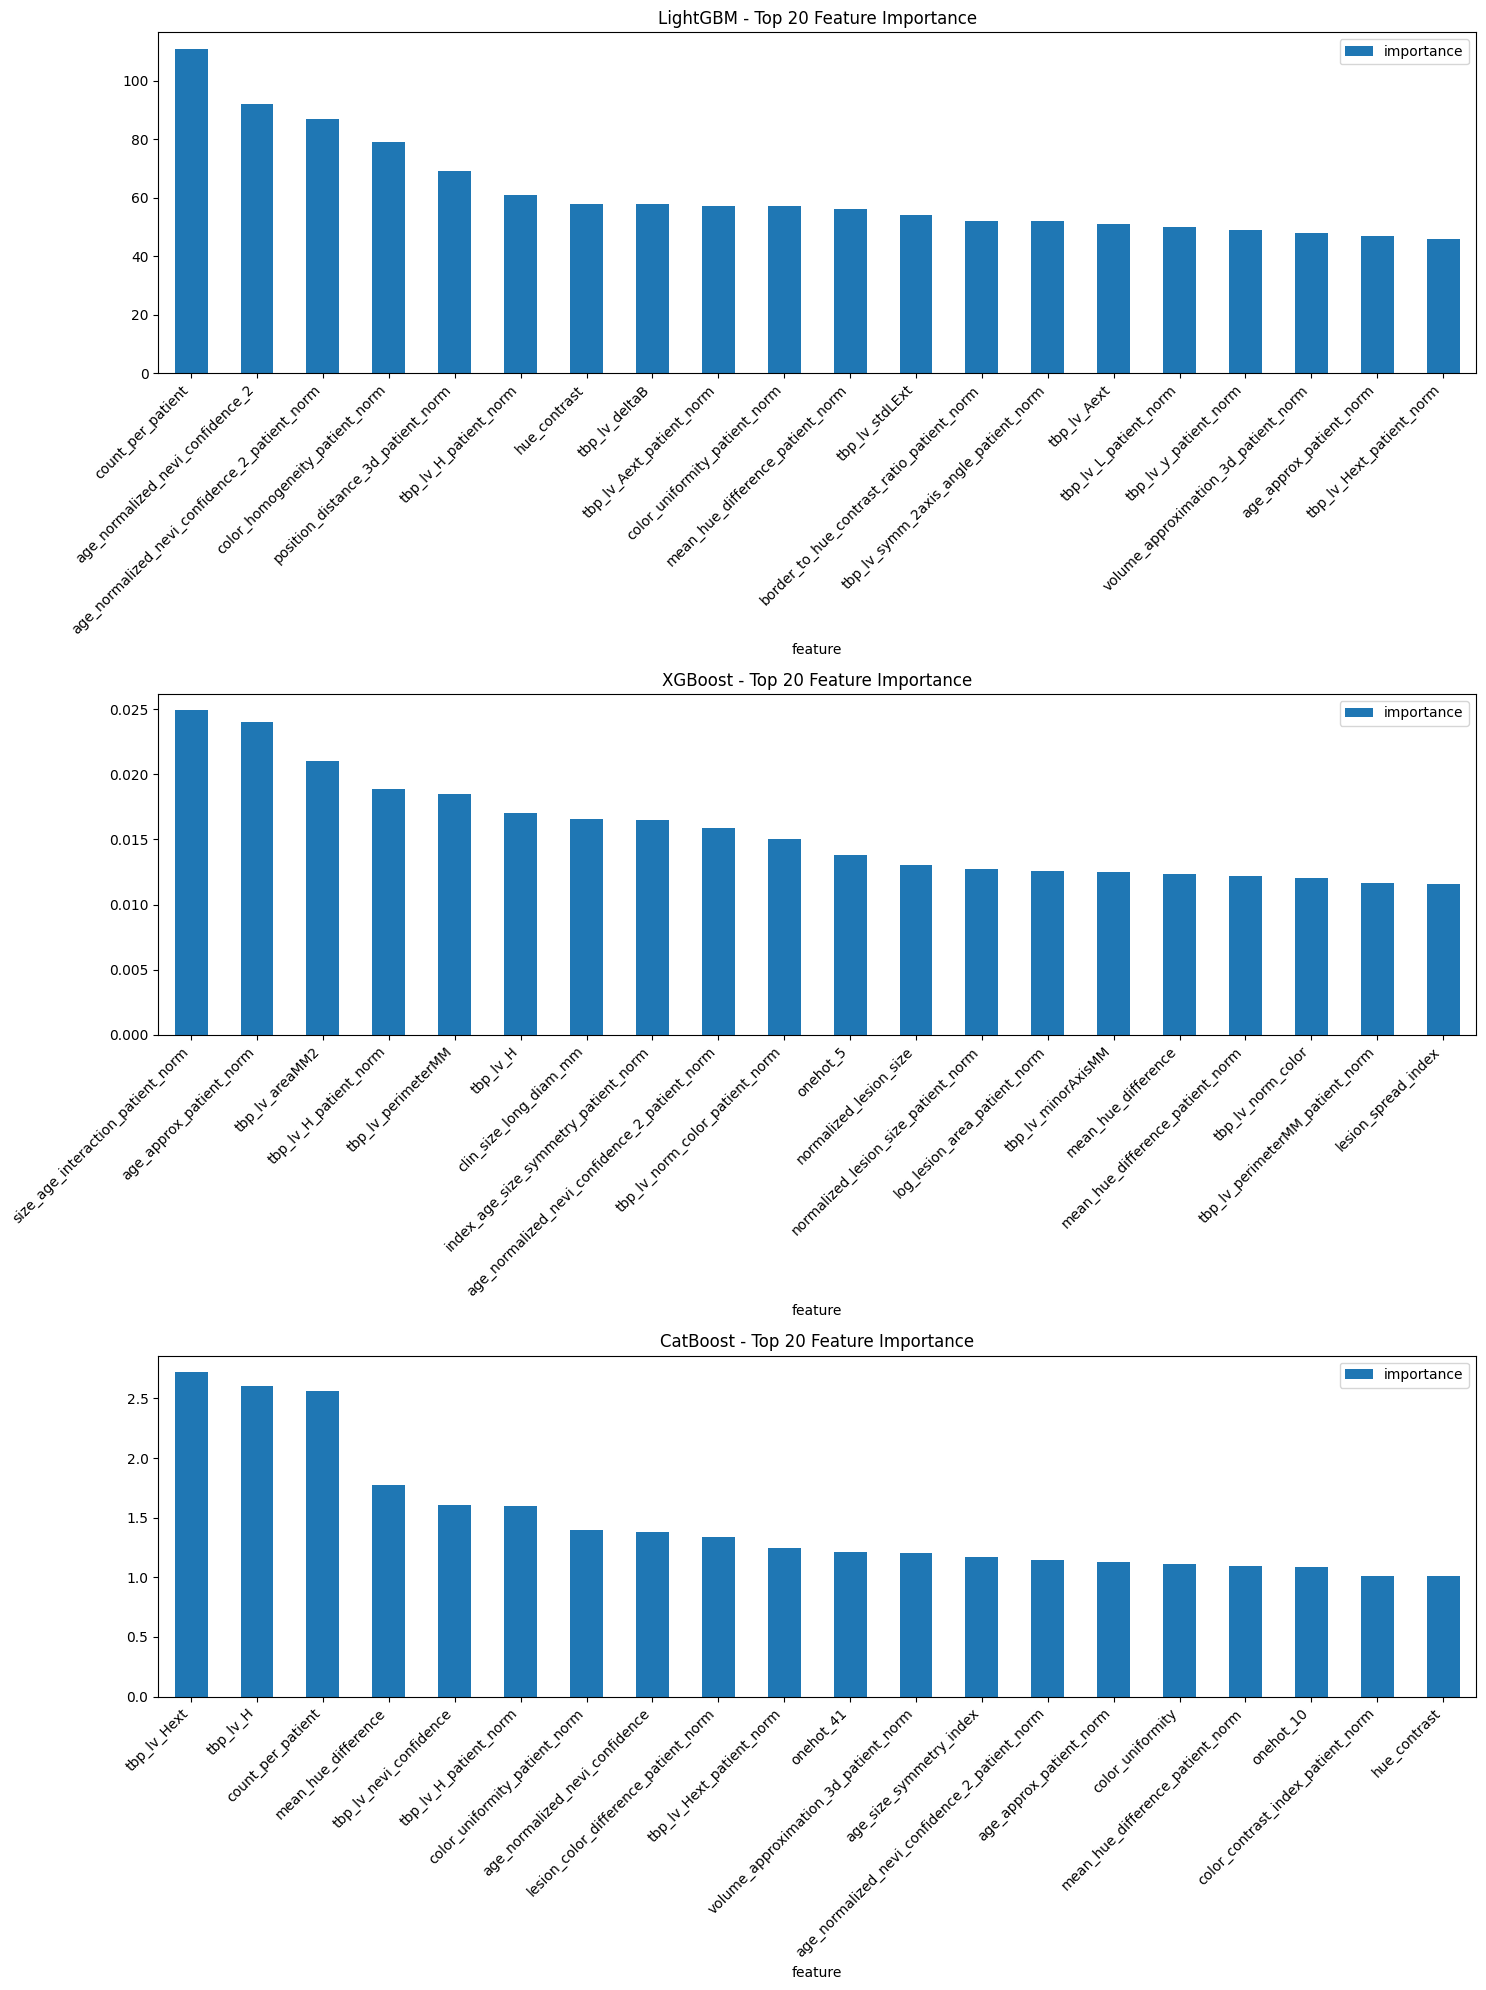

In [ ]:
def perform_feature_importance_analysis(X, y, feature_cols_without_image_cols, cat_cols, lgb_params, xgb_params, cb_params):
    # LightGBM feature importance
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(X[feature_cols_without_image_cols], y)
    lgb_feature_importance = lgb_model.feature_importances_
    lgb_feature_importance_df = pd.DataFrame({
        'feature': feature_cols_without_image_cols,
        'importance': lgb_feature_importance
    }).sort_values(by='importance', ascending=False)

    print("LightGBM Feature Importance:")
    print(lgb_feature_importance_df)

    # XGBoost feature importance
    xgb_model = xgb.XGBClassifier(**xgb_params, enable_categorical=True)
    xgb_model.fit(X[feature_cols_without_image_cols], y)
    xgb_feature_importance = xgb_model.feature_importances_
    xgb_feature_importance_df = pd.DataFrame({
        'feature': feature_cols_without_image_cols,
        'importance': xgb_feature_importance
    }).sort_values(by='importance', ascending=False)

    print("XGBoost Feature Importance:")
    print(xgb_feature_importance_df)

    # CatBoost feature importance
    cb_model = cb.CatBoostClassifier(**cb_params)
    cb_model.fit(X[feature_cols_without_image_cols], y, cat_features=cat_cols)
    cb_feature_importance = cb_model.feature_importances_
    cb_feature_importance_df = pd.DataFrame({
        'feature': feature_cols_without_image_cols,
        'importance': cb_feature_importance
    }).sort_values(by='importance', ascending=False)

    print("CatBoost Feature Importance:")
    print(cb_feature_importance_df)

    # Display settings for Pandas
    pd.set_option('display.max_rows', 30)
    pd.set_option('display.max_columns', None)

    # Least important features for each model
    least_important_lgb = lgb_feature_importance_df.sort_values(by='importance').head(30)
    least_important_xgb = xgb_feature_importance_df.sort_values(by='importance').head(30)
    least_important_cb = cb_feature_importance_df.sort_values(by='importance').head(30)

    print("\nLeast Important Features in LightGBM:")
    print(least_important_lgb)
    print("\nLeast Important Features in XGBoost:")
    print(least_important_xgb)
    print("\nLeast Important Features in CatBoost:")
    print(least_important_cb)

    # Common least important features across all models
    common_least_important_features = pd.merge(
        pd.merge(least_important_lgb[['feature']], least_important_xgb[['feature']], on='feature'),
        least_important_cb[['feature']],
        on='feature'
    )
    print("\nCommon Least Important Features in All Models:")
    print(common_least_important_features)

    # Visualize feature importance
    plt.figure(figsize=(15, 20))

    plt.subplot(3, 1, 1)
    lgb_feature_importance_df.head(20).plot(x='feature', y='importance', kind='bar', ax=plt.gca())
    plt.title('LightGBM - Top 20 Feature Importance')
    plt.xticks(rotation=45, ha='right')

    plt.subplot(3, 1, 2)
    xgb_feature_importance_df.head(20).plot(x='feature', y='importance', kind='bar', ax=plt.gca())
    plt.title('XGBoost - Top 20 Feature Importance')
    plt.xticks(rotation=45, ha='right')

    plt.subplot(3, 1, 3)
    cb_feature_importance_df.head(20).plot(x='feature', y='importance', kind='bar', ax=plt.gca())
    plt.title('CatBoost - Top 20 Feature Importance')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    return lgb_feature_importance_df, xgb_feature_importance_df, cb_feature_importance_df

# Usage
if DO_FEATURE_IMPORTANCE:
    lgb_importance, xgb_importance, cb_importance = perform_feature_importance_analysis(
        X, y, feature_cols_without_image_cols, cat_cols, lgb_params, xgb_params, cb_params
    )